<a href="https://colab.research.google.com/github/earandir/DataAnalysis/blob/main/Modulo04/CheckPoint/Proyecto_CheckPoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Módulo 04 - Proyecto CheckPoint

## Análisis de atención y soporte en Mesa de Ayuda

## 1. Objetivos:
* Obtener las órdenes de trabajo desde una base de datos
* Obtener la información de los agentes encargados
* Unir ambas tablas para obtener inforamción completa
* Analizar y transformar a Dataframes
* Verificar que los datos sean del tipo correcto
* Transformar las fechas en diferentes formatos para análisis
* Análisis exploratorio de los datos
* Gráficas de resultados

## 2. Desarrollo:

#### Importación de bibliotecas utilizadas

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis


### a) Obtener órdenes de trabajo:

Para iniciar el proyecto, es necesario leer la información de la órdenes. Esta inofrmación se encuentra en dos archivos:


*   Es necesario leer el encabezado de las solicitudes con el archivo: solicitudes.csv
*   El detalle del trabajo realizado en cada una de las solicitudes se encuentra en el archivo: solicitudesdetalle.csv

Después se necesario unir ambos registros para tener la información completa.



In [2]:
solicitudes = pd.read_csv('https://raw.githubusercontent.com/earandir/DataAnalysis/main/Modulo04/CheckPoint/solicitudes.csv', index_col=0)

solicitudes_detalle = pd.read_csv('https://raw.githubusercontent.com/earandir/DataAnalysis/main/Modulo04/CheckPoint/solicitudes_detalle.csv', index_col=0)

In [3]:
pd.merge(solicitudes, solicitudes_detalle, left_on='idSolicitud', right_index=True)

,idAgente_x,idUsuario,FechaCreacion_x,FechaResolucion,Categoria,SubCategoria,idModo,idModulo,ValorEncuesta,idSolicitud,idTipodeTrabajo,idAgente_y,FechaCreacion_y,FechaInicio,FechaFin,TiempoTranscurrido,TarifaAgente,CostoTrabajo
idSolicitud,,,,,,,,,,,,,,,,,,
15762,694,616,2018-09-19 05:23:43,NaN,Soporte Externo,Error,10,66,0,23941,352,64,2021-04-05 04:32:01,2021-03-24 22:38:00,2021-03-25 00:19:00,6060,262,22


Además de las solicitudes, faltaría agregar la información de los usuarios, los agentes, módulos y tipos de trabajo.

Pero en la base de datos encontramos un procedimiento que nos hace la unión de toda la información necesaria, así que vamos a usar esta vista para simplificar el proceso y no tener que unir todas las tablas.

In [4]:
registros = pd.read_csv('https://raw.githubusercontent.com/earandir/DataAnalysis/main/Modulo04/CheckPoint/registrosmesaservicio.csv', index_col=0)

registros.head(3)

,Solicitante,Modo,FechaCreacionSolicitud,Modulo,Agente,Categoria,SubCategoria,ValorEncuesta,AgenteTrabajo,Trabajo,FechaCreacionTrabajo,FechaInicio,FechaFin,TiempoTranscurrido,TarifaAgente,CostoTrabajo
idSolicitud,,,,,,,,,,,,,,,,
17804,Jaime,Web,2019-11-30 04:48:30,Zinc e-commerce,Sonia,Soporte Externo,Error,0,Sonia,Not Assigned,2020-01-02 17:50:30,2020-01-02 09:33:00,2020-01-02 09:40:00,420,242,21
17908,KENIA,Llamada,2020-01-03 01:17:50,Nomina,Sonia,Soporte Externo,Consulta,0,Sonia,Not Assigned,2020-01-02 19:23:02,2020-01-02 13:00:00,2020-01-02 13:24:00,1440,242,21
17909,David,Llamada,2020-01-03 01:50:12,Nomina,Sonia,Soporte Externo,Consulta,0,Sonia,Not Assigned,2020-01-02 19:53:51,2020-01-02 13:34:00,2020-01-02 13:54:00,1200,242,21


### b) Revisión de datos y conversión de tipos:
Al revisar los datos del DataFrame, encontramos las fechas registradas como tipo "Objeto", por lo que hacemos la conversión al tipo "datetime" para poder realizar operaciones con las fechas.

In [5]:
registros.dtypes

Solicitante               object
Modo                      object
FechaCreacionSolicitud    object
Modulo                    object
Agente                    object
Categoria                 object
SubCategoria              object
ValorEncuesta              int64
AgenteTrabajo             object
Trabajo                   object
FechaCreacionTrabajo      object
FechaInicio               object
FechaFin                  object
TiempoTranscurrido         int64
TarifaAgente               int64
CostoTrabajo               int64
dtype: object

In [6]:
dates_dict = {'FechaCreacionSolicitud':'datetime64[ns]' \
              , 'FechaCreacionTrabajo': 'datetime64[ns]' \
              , 'FechaInicio': 'datetime64[ns]' \
              , 'FechaFin': 'datetime64[ns]'}
registros = registros.astype(dates_dict)     

registros.dtypes

Solicitante                       object
Modo                              object
FechaCreacionSolicitud    datetime64[ns]
Modulo                            object
Agente                            object
Categoria                         object
SubCategoria                      object
ValorEncuesta                      int64
AgenteTrabajo                     object
Trabajo                           object
FechaCreacionTrabajo      datetime64[ns]
FechaInicio               datetime64[ns]
FechaFin                  datetime64[ns]
TiempoTranscurrido                 int64
TarifaAgente                       int64
CostoTrabajo                       int64
dtype: object

### c) Análisis Exploratorio de datos:

Una vez que contamos con la información completa, es momento de empezar a resolver dudas en relación a estos datos.

####1) ¿De qué módulos piden ayuda?

Para responder esta pregunta, es necesario agrupar por módulo todas las solicitudes y agregar la columna con el conteo de registros, dejando los 10 módulos que  más tienen registros.

In [7]:
top_modulos = registros.groupby('Modulo') \
  .agg(conteo=('Modulo', 'size')) \
  .reset_index()

top_modulos = top_modulos.sort_values('conteo', ascending=False)

top_modulos = top_modulos[:5]


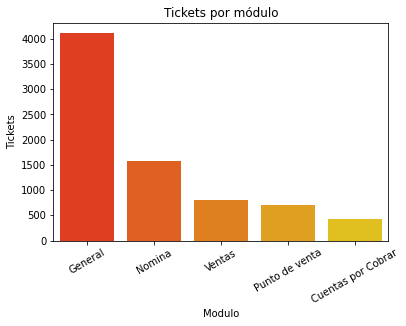

In [8]:
ax = sns.barplot(y= top_modulos['conteo'], x = top_modulos['Modulo'], data = top_modulos, palette=('autumn'))
ax.set_title('Tickets por módulo')
ax.set_ylabel('Tickets')
ax.tick_params(axis='x', rotation=30)
sns.set_context('notebook')

####2) ¿De qué forma contactan al equipo de soporte?

Esta pregunta se puede responder de una manera muy similar a la pregunta anterior, utilizando el campo del modo de contacto.

In [9]:
modos = registros.groupby('Modo') \
  .agg(conteo=('Modo', 'size')) \
  .reset_index()

modos = modos.sort_values('conteo', ascending=False)

top_modos = modos[:5]


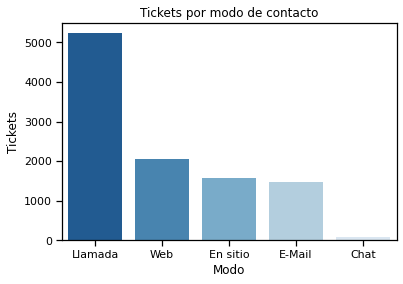

In [10]:
ax = sns.barplot(y= top_modos['conteo'], x = top_modos['Modo'], data = top_modos, palette=('Blues_r'))
ax.set_title('Tickets por modo de contacto')
ax.set_ylabel('Tickets')
sns.set_context('notebook')

####3) ¿Quién es la persona a la que más tiempo se le ha invertido?

En este caso, es necesario analizar los registros por usuario y sumar el tiempo invertido en cada una de las tareas que se hayan realizdo en sus casos de soporte técnico.

In [11]:
soporte_externo = registros.loc[registros['Categoria'] == 'Soporte Externo']

tiempo_usuario = soporte_externo.groupby('Solicitante') \
  .agg(tiempo_invertido=('TiempoTranscurrido', 'sum')) \
  .reset_index()

tiempo_usuario = tiempo_usuario.sort_values('tiempo_invertido', ascending=False)

tiempo_usuario['tiempo_invertido'] = tiempo_usuario['tiempo_invertido'] // 86400

top_usuarios = tiempo_usuario[:5]


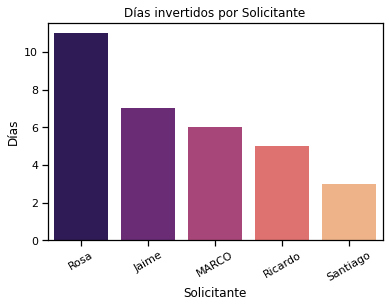

In [12]:
ax = sns.barplot(y= top_usuarios['tiempo_invertido'], x = top_usuarios['Solicitante'], data = top_usuarios, palette=('magma'))
ax.set_title('Días invertidos por Solicitante')
ax.set_ylabel('Días')
ax.tick_params(axis='x', rotation=30)
sns.set_context('notebook')

####4) ¿Cuantos casos se han recibido en cada mes del año?

Para responder esta pregunta, se requiere transformar el campo de la fecha para obtener el mes que le corresponde para poder sumar los casos por cada uno de los meses.

In [13]:
months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]

In [14]:
soporte_externo = registros.loc[registros['Categoria'] == 'Soporte Externo']
soporte_externo['MesCreacion'] = soporte_externo['FechaCreacionSolicitud'].apply(lambda x: x.strftime('%B'))
soporte_externo['MesCreacion'] = pd.Categorical(soporte_externo['MesCreacion'], categories=months, ordered=True)
soporte_externo['YearCreacion'] = soporte_externo['FechaCreacionSolicitud'].apply(lambda x: x.strftime('%Y'))

soporte_grouped = soporte_externo.groupby(['YearCreacion','MesCreacion']) \
  .agg(conteo=('FechaCreacionSolicitud', 'size')) \
  .reset_index()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

¿Cuántos tickets se reciben en promedio al mes al año pasado?

In [15]:
mean = soporte_grouped.loc[soporte_grouped['YearCreacion'] == '2020']['conteo'].mean()

print(f'El promedio de tickets por mes el año pasado fue de: {round(mean, ndigits=2)}') 

El promedio de tickets por mes el año pasado fue de: 412.83


In [16]:
maxmes = soporte_grouped.iloc[ soporte_grouped.loc[soporte_grouped['YearCreacion'] == '2020']['conteo'].idxmax() , ]['MesCreacion']
maxtickets = soporte_grouped.iloc[ soporte_grouped.loc[soporte_grouped['YearCreacion'] == '2020']['conteo'].idxmax() , ]['conteo']

print(f'El més con más trabajo fue: {maxmes}, con {maxtickets} tickets.')

El més con más trabajo fue: June, con 488 tickets.


In [17]:
soporte_grouped.describe()

,conteo
count,48.000000
mean,149.458333
std,217.483671
min,0.000000
25%,0.000000
50%,0.000000
75%,397.000000
max,644.000000


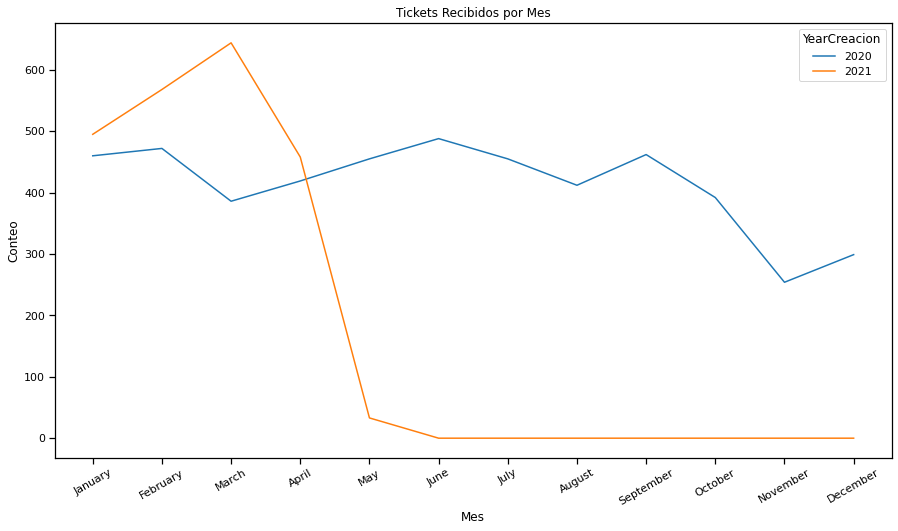

In [85]:
a4_dims = (15, 8)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.lineplot(data=soporte_grouped[(soporte_grouped['YearCreacion'] == '2020') | (soporte_grouped['YearCreacion'] == '2021')], x='MesCreacion', y='conteo', hue="YearCreacion")
ax.set_title('Tickets Recibidos por Mes')
ax.set_ylabel('Conteo')
ax.set_xlabel('Mes')
ax.tick_params(axis='x', rotation=30)
sns.set_context('talk')


anaálisis exploratorio de datos
tiempo invertido
tikets recibidos



In [19]:
soporte_externo.head()

,Solicitante,Modo,FechaCreacionSolicitud,Modulo,Agente,Categoria,SubCategoria,ValorEncuesta,AgenteTrabajo,Trabajo,FechaCreacionTrabajo,FechaInicio,FechaFin,TiempoTranscurrido,TarifaAgente,CostoTrabajo,MesCreacion,YearCreacion
idSolicitud,,,,,,,,,,,,,,,,,,
17804,Jaime,Web,2019-11-30 04:48:30,Zinc e-commerce,Sonia,Soporte Externo,Error,0,Sonia,Not Assigned,2020-01-02 17:50:30,2020-01-02 09:33:00,2020-01-02 09:40:00,420,242,21,November,2019
17908,KENIA,Llamada,2020-01-03 01:17:50,Nomina,Sonia,Soporte Externo,Consulta,0,Sonia,Not Assigned,2020-01-02 19:23:02,2020-01-02 13:00:00,2020-01-02 13:24:00,1440,242,21,January,2020
17909,David,Llamada,2020-01-03 01:50:12,Nomina,Sonia,Soporte Externo,Consulta,0,Sonia,Not Assigned,2020-01-02 19:53:51,2020-01-02 13:34:00,2020-01-02 13:54:00,1200,242,21,January,2020
17907,Claudia,Llamada,2020-01-03 00:24:50,Nomina,Sonia,Soporte Externo,Consulta,0,Sonia,Not Assigned,2020-01-02 19:55:49,2020-01-02 12:17:00,2020-01-02 12:35:00,1080,242,21,January,2020
17911,Victor,Llamada,2020-01-03 04:16:54,General,Carlos Enrique,Soporte Externo,Candados o PDA,0,Carlos Enrique,Llamada externa,2020-01-02 22:22:29,2020-01-02 22:15:00,2020-01-02 22:15:00,0,221,25,January,2020


In [20]:
soporte = soporte_externo.groupby(['Agente','Modulo']).agg({'TiempoTranscurrido': 'sum'}).reset_index()

De los diferentes módulos que existen, examinamos el total de módulos atendidos por cada agente:

In [22]:
soporte['Agente'].value_counts()

Carlos Enrique    26
Sonia             24
Angelica          23
Adrian            22
Rosa              21
Jaime             20
Manuel            19
Edgar             11
Ricardo            7
Oscar              3
Name: Agente, dtype: int64

Analizamos la información de los módulos para poder crear un dicccionario de conversión estableciendo el número que le corresponde a cada módulo y agente:

In [23]:
soporte['Modulo'].value_counts()

General                                10
PDA o Candados                         10
Punto de venta                          9
Ventas                                  9
Inventarios                             8
Nomina                                  8
Contabilidad                            8
Zinc e-commerce                         8
Candados Hasp                           7
Compras                                 7
Administrador de Sucursales (AS)        7
Cuentas por Cobrar                      7
Cuentas por Pagar                       7
Reporteador                             7
Bancos                                  7
Respaldos Automáticos                   7
SiCS                                    7
Microsip en ruta                        7
Administracion de empresa               7
CEO Movil                               6
ADD                                     5
Bases de datos                          5
API                                     4
Actualizador de licencias de renta

In [25]:
soporte['Agente'] = soporte['Agente'].astype('category')
soporte['Modulo'] = soporte['Modulo'].astype('category')
soporte.dtypes

Agente                category
Modulo                category
TiempoTranscurrido       int64
dtype: object

In [26]:
#soporte['Agente']= soporte['Agente'].cat.codes
#soporte['Modulo']= soporte['Modulo'].cat.codes

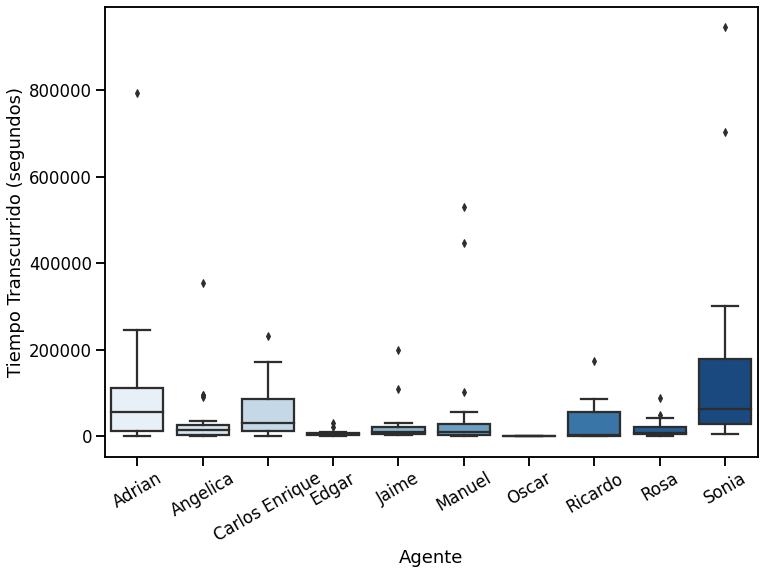

In [86]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.boxplot(data=soporte, x='Agente', y='TiempoTranscurrido',  palette='Blues')
ax.set_ylabel('Tiempo Transcurrido (segundos)')
ax.set_xlabel('Agente')
ax.tick_params(axis='x', rotation=30)
sns.set_context('notebook')

Eliminando valores atípicos

In [29]:
iqr = soporte['TiempoTranscurrido'].quantile(0.75) - soporte['TiempoTranscurrido'].quantile(0.25)
filtro_inferior = soporte['TiempoTranscurrido'] > soporte['TiempoTranscurrido'].quantile(0.25) - (iqr * 1.5)
filtro_superior = soporte['TiempoTranscurrido'] < soporte['TiempoTranscurrido'].quantile(0.75) + (iqr * 1.5)

soporte_filtrado = soporte[filtro_inferior & filtro_superior]

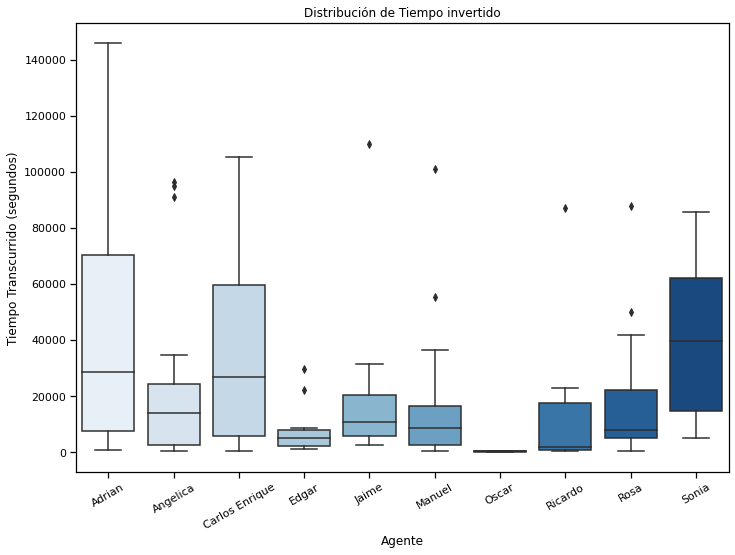

In [87]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.boxplot(data=soporte_filtrado, x='Agente', y='TiempoTranscurrido',  palette='Blues')
ax.tick_params(axis='x', rotation=30)
ax.set_ylabel('Tiempo Transcurrido (segundos)')
ax.set_xlabel('Agente')
ax.set_title('Distribución de Tiempo invertido')
sns.set_context('notebook')

In [31]:
soporte_filtrado.describe()

,TiempoTranscurrido
count,155.000000
mean,25420.645161
std,30943.905463
min,120.000000
25%,3900.000000
50%,11100.000000
75%,30900.000000
max,145860.000000


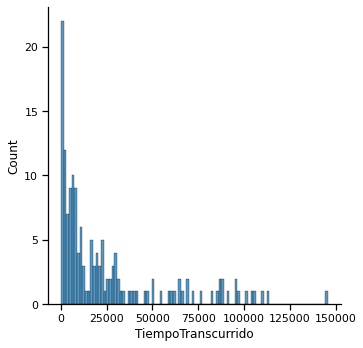

In [32]:
sns.displot(soporte_filtrado['TiempoTranscurrido'], kde=False, bins=100);

In [39]:
cur = kurtosis(soporte_filtrado['TiempoTranscurrido'])
sk = skew(soporte_filtrado['TiempoTranscurrido'])
print(f'Curtosis: {cur}')
print(f'Asimetría: {sk}')

Curtosis: 1.7122686563107026
Asimetría: 1.5854026246396231


In [43]:
soporte_cross = pd.soporte_cross(index=soporte_filtrado.Agente, columns=soporte_filtrado.Modulo, values=soporte_filtrado.TiempoTranscurrido, aggfunc='sum')

In [57]:
soporte_cross.fillna(0, inplace=True)

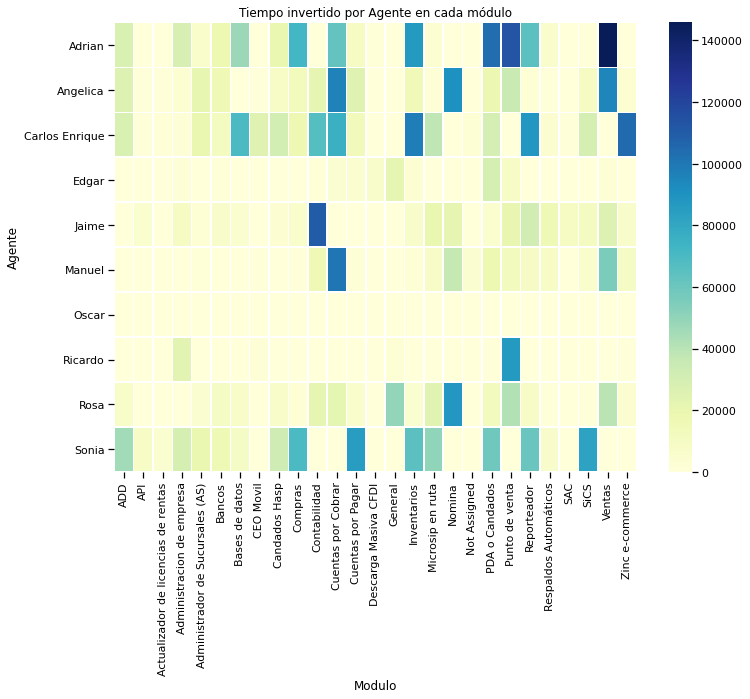

In [79]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.heatmap(soporte_cross, cmap='YlGnBu', linewidths=.5);
ax.set_title('Tiempo invertido por Agente en cada módulo')
ax.tick_params(axis='x', rotation=90)
sns.set_context('notebook')

revisar carga de trabajo por agente y promedios de atención por módulo

recomendación de mejor agente para un módulo